In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt

In [5]:
train_data_dir = '../CRAI/split/train'
# test_data_dir = '../CRAI/split/test'
val_data_dir = '../CRAI/split/val'

In [6]:
train_data = ImageFolder(train_data_dir, transform=transforms.Compose([
    transforms.Resize((150, 150)), transforms.ToTensor()
]))

# test_data = ImageFolder(test_data_dir, transforms.Compose([
    # transforms.Resize((150, 150)), transforms.ToTensor()
# ]))

val_data = ImageFolder(val_data_dir, transforms.Compose([
    transforms.Resize((150, 150)), transforms.ToTensor()
]))

In [7]:
img, label = train_data[0]
print(img.shape, label)
print("Following classes are: \n", train_data.classes)

torch.Size([3, 150, 150]) 0
Following classes are: 
 ['glass', 'metal', 'mixed', 'paper', 'plastic']


Label : plastic


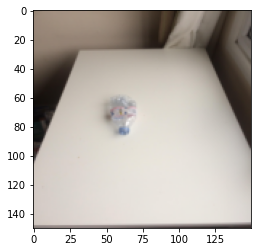

In [8]:
def display_img(img, label):
    print(f"Label : {train_data.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))

display_img(*train_data[550])

In [9]:
print(f"Length of Train data: {len(train_data)}")
print(f"Length of Val data: {len(val_data)}")

Length of Train data: 983
Length of Val data: 425


In [10]:
train_dl = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_data, batch_size=8, num_workers=0, pin_memory=True)

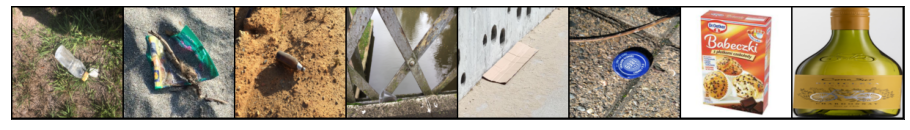

In [11]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [12]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']
        ))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class CNN(ImageClassificationBase):

    def __init__(self):

        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(123904, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5),
        )

    def forward(self, xb):
        return self.network(xb)

In [14]:
model = CNN()
model

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=123904, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024,

In [15]:
for images, labels in train_dl:
    print("images.shape:", images.shape)
    out = model(images)
    print("out.shape:", out.shape)
    print("out[0]:", out[0])
    break

images.shape: torch.Size([8, 3, 150, 150])


D:\Anaconda\envs\CRAI\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


out.shape: torch.Size([8, 5])
out[0]: tensor([ 0.0052, -0.0263, -0.0326, -0.0164,  0.0284], grad_fn=<SelectBackward>)


In [16]:
def get_default_device():
    """ Set Device to GPU or CPU """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=123904, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024,

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [20]:
model = to_device(CNN(), device)

In [21]:
evaluate(model, val_dl)

{'val_loss': 1.6086019277572632, 'val_acc': 0.1527777761220932}

In [22]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.00001

In [23]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.3993, val_loss: 1.3223, val_acc: 0.5278
Epoch [1], train_loss: 1.3289, val_loss: 1.3183, val_acc: 0.5278
Epoch [2], train_loss: 1.3264, val_loss: 1.3108, val_acc: 0.5278
Epoch [3], train_loss: 1.3198, val_loss: 1.2993, val_acc: 0.5278
Epoch [4], train_loss: 1.3033, val_loss: 1.2761, val_acc: 0.5278
Epoch [5], train_loss: 1.2869, val_loss: 1.2578, val_acc: 0.5278
Epoch [6], train_loss: 1.2791, val_loss: 1.2490, val_acc: 0.5440
Epoch [7], train_loss: 1.2650, val_loss: 1.2353, val_acc: 0.5440
Epoch [8], train_loss: 1.2599, val_loss: 1.2383, val_acc: 0.5301
Epoch [9], train_loss: 1.2537, val_loss: 1.2403, val_acc: 0.5347
Epoch [10], train_loss: 1.2488, val_loss: 1.2192, val_acc: 0.5509
Epoch [11], train_loss: 1.2408, val_loss: 1.2172, val_acc: 0.5509
Epoch [12], train_loss: 1.2382, val_loss: 1.2135, val_acc: 0.5509
Epoch [13], train_loss: 1.2264, val_loss: 1.2045, val_acc: 0.5509
Epoch [14], train_loss: 1.2172, val_loss: 1.1999, val_acc: 0.5509
Epoch [15], train_lo

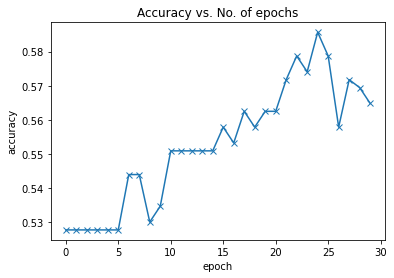

In [24]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')


plot_accuracies(history)

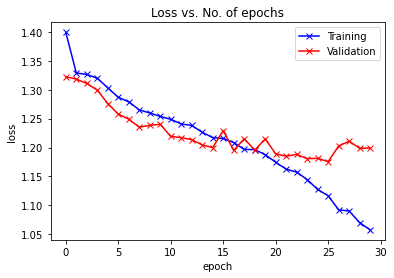

In [25]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

### Wnioski i rzeczy do zrobienia po drugim przejściu:

* Poświęcono zbiór testowy na rzecz walidacyjnego — nie wiem, czy było warto
* Tak czy inaczej, trzeba będzie w krótkim czasie wydzielić/dorobić zbiór testowy.
* Prawdopodobnie ustawione jest za dużo epok (nie jestem pewny).
* Trzeba sprawdzić trening na innym/większym LR (learning rate)
* ### Napisać "własny" model CNN (na razie używam z tutoriala)
* Sprawdzić dataset pod względem jakościowym.
* Zastanowić się, czy zmniejszanie zdjęć do wymiarów 150 × 150 nie jest zbyt duże.